In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cmath
import datetime
from scipy.linalg import expm

In [2]:
from qutip import Qobj, identity, sigmax, sigmay, sigmaz, tensor
from qutip.qip.algorithms import qft
from qutip import *
#import qutip.logging_utils as logging
#logger = logging.get_logger()
#Set this to None or logging.WARN for 'quiet' execution
#log_level = logging.INFO
#QuTiP control modules
import qutip.control.pulseoptim as cpo
import qutip.control.pulsegen as pulsegen

example_name = 'QFT'

In [3]:
# no. of levels for each transmon.
N = 2
f_1 = 5.03103*(10**3)
f_2 = 4.92672*(10**3)
delta_1 = -271
delta_2 = -269
# the lists of variables for all 6 qubits.
f = [f_1, f_2] #the coefficient of the bare hamiltonian for each qubit
delta = [delta_1, delta_2] #the coefficient for the Kerr term
#      11    12     21    22
J = [[ 0.0, 4.03],[4.03, 0.0]]

# defines a_i.
a_1 = tensor(destroy(N), qeye(N))
a_2 = tensor(qeye(N), destroy(N))

a = [a_1, a_2]

# defines the identity matrix
identity_matrix = tensor(qeye(N), qeye(N))
# defines the zero matrix
zero_ = Qobj(np.zeros((N,N)))
zero_matrix = tensor(zero_, zero_)

def Hamiltonian(f, delta, J, N):
    
    # defines the bare Hamiltonian
    H_bare = zero_matrix
    for i in range(2):
        e = (f[i]-f[1])*(Qobj(a[i]).dag()*Qobj(a[i])) + 0.5*delta[i]*(Qobj(a[i]).dag()*Qobj(a[i]))*((Qobj(a[i]).dag()*Qobj(a[i])) - identity_matrix)
        H_bare = H_bare + (2*np.pi)*e
       
    # defines the interaction Hamiltonian (the spins are labelled 0-5)
    H_int = zero_matrix
    for i in range(2):
        # defines the interaction with the next neighbour on the right of the ith spin - which is the ((i+1) mod 6)-th spin..
        p_neighbor_1 = (J[i][(i + 1)%2])*(Qobj(a[i]).dag()*Qobj(a[(i+1)%2]) + Qobj(a[i])*Qobj(a[(i+1)%2]).dag())
        H_int = H_int + (2*np.pi)*0.5*(p_neighbor_1) #to prevent double counting, we need to multiply by 0.5.  
    
    #defines the full Hamiltonian
    Ham = H_bare + H_int
    return Ham

H_d = Hamiltonian(f, delta, J, N)
H_c = [ 25.4*(2*np.pi)*Qobj(a[0].dag() + a[0])/2,25.4*(2*np.pi)*Qobj(a[1].dag() + a[1])/2]
n_ctrls = len(H_c)

# start point for the gate evolution
U_0 = identity_matrix
# Target for the gate evolution - Quantum Fourier Transform gate
from qutip.qip.operations import cnot
U_targ = cnot()#(tensor(identity(2),identity(2))-1j*tensor(sigmaz(),sigmax()))*(1/np.sqrt(2))
H_d

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[  0.           0.           0.           0.        ]
 [  0.           0.          25.32123679   0.        ]
 [  0.          25.32123679 655.39905939   0.        ]
 [  0.           0.           0.         655.39905939]]

In [4]:
if N==3:
    U_targ
    U_targ = np.zeros((N**2,N**2))
    
    U_targ[0][0] = 1
    U_targ[1][1] = 1
    U_targ[2][2] = 1
    U_targ[3][4] = 1
    U_targ[4][3] = 1
    U_targ[5][5] = 1
    U_targ[6][6] = 1
    U_targ[7][7] = 1
    U_targ[8][8] = 1
    U_targ=Qobj(U_targ)
else:
    U_targ = cnot()#(tensor(identity(2),identity(2))-1j*tensor(sigmaz(),sigmax()))*(1/np.sqrt(2))
U_targ

Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=True
Qobj data =
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]]

In [27]:
# Duration of each timeslot
#dt = 0.001
# List of evolution times to try
evo_times = [0.288, 3, 6]
n_evo_times = len(evo_times)
evo_time = evo_times[0]
n_ts = 288#int(float(evo_time) / dt)
#Empty list that will hold the results for each evolution time
results = list()

In [28]:
# Fidelity error target
fid_err_targ = 1e-6
# Maximum iterations for the optisation algorithm
max_iter = 2000
# Maximum (elapsed) time allowed in seconds
max_wall_time = 300
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

In [29]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = 'SINE'

In [30]:
#Set to None to suppress output files
f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)

In [31]:
optim = cpo.create_pulse_optimizer(H_d, H_c, U_0, U_targ, n_ts, evo_time, 
                amp_lbound=-1 , amp_ubound=1 , 
                fid_err_targ=fid_err_targ, min_grad=min_grad, 
                max_iter=max_iter, max_wall_time=max_wall_time, 
                optim_method='fmin_l_bfgs_b',
                method_params={'max_metric_corr':20, 'accuracy_factor':1e8},
                dyn_type='UNIT', 
                fid_params={'phase_option':'PSU'},
                init_pulse_type=p_type, gen_stats=True)

# **** get handles to the other objects ****
optim.test_out_files = 0
dyn = optim.dynamics
dyn.test_out_files = 0
gen = optim.pulse_generator
#gen,p_gen

In [32]:
# Generate the tau (duration) and time (cumulative) arrays
    # so that it can be used to create the pulse generator
    # with matching timeslots
dyn.init_timeslots()
# Create a new pulse generator for the new dynamics
p_gen = pulsegen.create_pulse_gen(p_type, dyn)
#p_gen.PulseGenGaussianEdge(dyn=dyn, decay_time=0.016)
#p_gen.scaling = 0.2
#p_gen.lbound = -10
#p_gen.ubound = 50*2

#Generate different initial pulses for each of the controls
init_amps = np.zeros([n_ts, n_ctrls])
if (p_gen.periodic):
    phase_diff = np.pi / n_ctrls
    for j in range(n_ctrls):
        init_amps[:, j] = p_gen.gen_pulse(freq=11,start_phase=phase_diff*j)
elif (isinstance(p_gen, pulsegen.PulseGenLinear)):
    for j in range(n_ctrls):
        p_gen.scaling = float(j) - float(n_ctrls - 1)/2
        init_amps[:, j] = p_gen.gen_pulse()
elif (isinstance(p_gen, pulsegen.PulseGenZero)):
    for j in range(n_ctrls):
        p_gen.offset = sf = float(j) - float(n_ctrls - 1)/2
        init_amps[:, j] = p_gen.gen_pulse()
elif (isinstance(p_gen, pulsegen.PulseGenGaussianEdge)):
    for j in range(n_ctrls):        
        p_gen.decay_time = evo_time/5
        gen.ramping_pulse=p_gen.gen_pulse()
        gen.init_pulse()
        init_amps[:, j] = gen.gen_pulse()
else:
    # Should be random pulse
    for j in range(n_ctrls):
        init_amps[:, j] = p_gen.gen_pulse()
#for j in range(len(init_amps[:, 0])):
#    init_amps[j, 0] = -0.3#p_gen.gen_pulse()


dyn.initialize_controls(init_amps)
init_amps

array([[ 0.00000000e+00,  1.00000000e+00],
       [ 6.90600210e-02,  9.97612507e-01],
       [ 1.37790281e-01,  9.90461427e-01],
       [ 2.05862595e-01,  9.78580907e-01],
       [ 2.72951917e-01,  9.62027677e-01],
       [ 3.38737898e-01,  9.40880777e-01],
       [ 4.02906410e-01,  9.15241184e-01],
       [ 4.65151049e-01,  8.85231327e-01],
       [ 5.25174598e-01,  8.50994502e-01],
       [ 5.82690445e-01,  8.12694189e-01],
       [ 6.37423953e-01,  7.70513273e-01],
       [ 6.89113770e-01,  7.24653166e-01],
       [ 7.37513079e-01,  6.75332850e-01],
       [ 7.82390772e-01,  6.22787829e-01],
       [ 8.23532560e-01,  5.67269004e-01],
       [ 8.60741991e-01,  5.09041477e-01],
       [ 8.93841390e-01,  4.48383284e-01],
       [ 9.22672709e-01,  3.85584067e-01],
       [ 9.47098277e-01,  3.20943691e-01],
       [ 9.67001465e-01,  2.54770813e-01],
       [ 9.82287233e-01,  1.87381408e-01],
       [ 9.92882593e-01,  1.19097259e-01],
       [ 9.98736951e-01,  5.02444228e-02],
       [ 9.

In [33]:
?p_gen.init_pulse

Signature: p_gen.init_pulse(num_waves=None, wavelen=None, freq=None, start_phase=None)
Docstring:
Calculate the wavelength, frequency, number of waves etc
from the each other and the other parameters
If num_waves is given then the other parameters are worked from this
Otherwise if the wavelength is given then it is the driver
Otherwise the frequency is used to calculate wavelength and num_waves
File:      c:\users\hp\appdata\roaming\python\python311\site-packages\qutip_qtrl\pulsegen.py
Type:      method

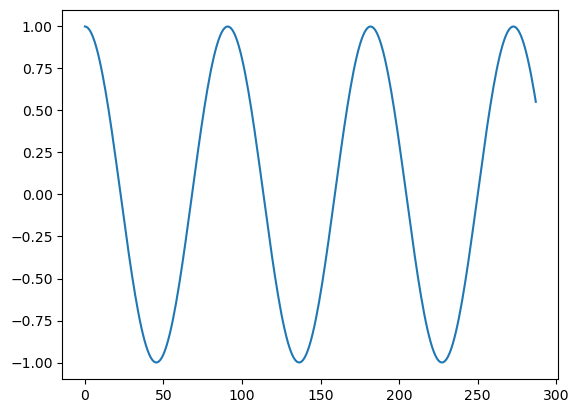

In [34]:
plt.plot(init_amps[:,1])

In [35]:

    
# Save initial amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_initial_" + f_ext
    dyn.save_amps(pulsefile)
    print("Initial amplitudes output to file: " + pulsefile)

print("***********************************")
print("\n+++++++++++++++++++++++++++++++++++")
print("Starting pulse optimisation for T={}".format(evo_time))
print("+++++++++++++++++++++++++++++++++++\n")
results = optim.run_optimization()

    # Save final amplitudes to a text file
if f_ext is not None:
    pulsefile = "ctrl_amps_final_" + f_ext
    dyn.save_amps(pulsefile)
    print("Final amplitudes output to file: " + pulsefile)
    
# Report the results
#results.stats.report()
#print("Final evolution\n{}\n".format(results.evo_full_final))
print("********* Summary *****************")
print("Final fidelity error {}".format(results.fid_err))
print("Final gradient normal {}".format(results.grad_norm_final))
print("Terminated due to {}".format(results.termination_reason))
print("Number of iterations {}".format(results.num_iter))
print("Completed in {} HH:MM:SS.US".format(
            datetime.timedelta(seconds=results.wall_time)))

Initial amplitudes output to file: ctrl_amps_initial_QFT_n_ts288_ptypeSINE.txt
***********************************

+++++++++++++++++++++++++++++++++++
Starting pulse optimisation for T=0.288
+++++++++++++++++++++++++++++++++++

Final amplitudes output to file: ctrl_amps_final_QFT_n_ts288_ptypeSINE.txt
********* Summary *****************
Final fidelity error 4.083463782078578e-05
Final gradient normal 0.00019851682613057265
Terminated due to function converged
Number of iterations 382
Completed in 0:00:53.594631 HH:MM:SS.US


(288,)


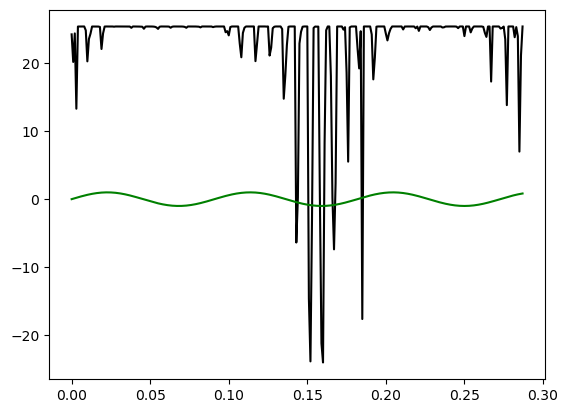

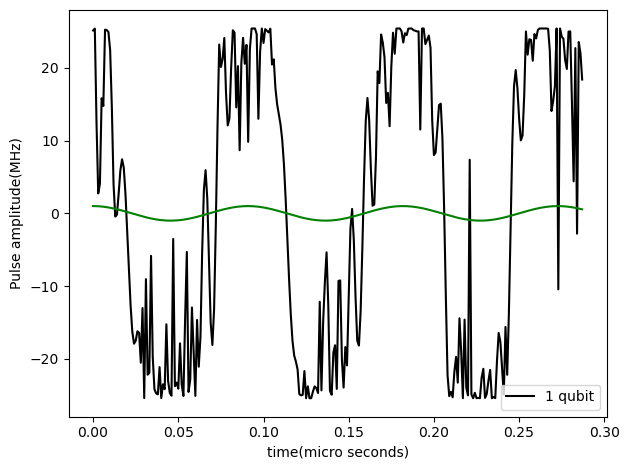

Fidelity :  0.9999591653621792


Quantum object: dims=[[2, 2], [2, 2]], shape=(4, 4), type='oper', dtype=Dense, isherm=False
Qobj data =
[[ 0.99995433-5.55111512e-17j  0.00584504-6.90170253e-03j
   0.00259563+1.99456961e-04j -0.00143434+8.42424599e-04j]
 [-0.005888  -6.87364615e-03j  0.99994025-5.06772773e-03j
   0.00135223-2.36647686e-04j -0.00316228+8.15042959e-05j]
 [ 0.00141289+7.96634205e-04j  0.0031755 +3.70137307e-05j
   0.00207437+6.90753355e-03j  0.99995846-4.28305535e-03j]
 [-0.00259671+2.29669669e-04j -0.00137484-1.82804871e-04j
   0.99995999-4.39689941e-03j -0.00200649+6.92339601e-03j]]

In [36]:
print(results.final_amps[:,0].shape)
plt.plot(results.time[:-1], 25.4*results.final_amps[:,0]*2/2,color = 'black', label='2 qubit')
plt.plot(results.time[:-1], results.initial_amps[:,0],color = 'green')
#plt.tight_layout()
plt.show()
#print(results.final_amps[:,1].shape)
plt.plot(results.time[:-1], 25.4*results.final_amps[:,1]*2/2,color = 'black', label='1 qubit')
#plt.plot(results.time[:-1], 25.4*np.sin(2*np.pi*(f_1-f_2)*np.linspace(0,0.2,200)),color = 'green', label='1 qubit')
plt.plot(results.time[:-1], results.initial_amps[:,1],color = 'green')
plt.xlabel("time(micro seconds)")
plt.ylabel('Pulse amplitude(MHz)')
plt.tight_layout()
plt.legend()
plt.savefig("pulse.png")

plt.show()
U=results.evo_full_final
print("Fidelity : ",1-results.fid_err)
U*np.exp(-1j*cmath.polar(U[0][0])[1])

In [17]:
from scipy.linalg import expm
U=identity(9)
fid=[]
for i in range(len(results.final_amps[:,1])):
    U=Qobj(expm(0.001*1j*(H_d.full()+results.final_amps[i,0]*H_c[0].full()+results.final_amps[i,1]*H_c[1].full())))*U
    fid.append(np.abs((Qobj(U_targ.dag().full())*U).tr())/4)
#U=U*np.exp(-1j*cmath.polar(U[0][0])[1])
plt.xlabel("time(micro seconds)")
plt.ylabel('Fidelity')
plt.plot(results.time[:-1],fid)

plt.savefig("fidelity.png")

plt.show()

TypeError: incompatible dimensions [[4], [4]] and [[9], [9]]